## 가위바위보 분류기를 만들자

### 데이터 불러오기 + Resize 하기

In [1]:
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import cv2
import os

In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [3]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

700  images to be resized.
700  images resized.
가위 이미지 resize 완료!


In [4]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

700  images to be resized.
700  images resized.
바위 이미지 resize 완료!


In [5]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

700  images to be resized.
700  images resized.
보 이미지 resize 완료!


In [6]:
import numpy as np

def load_data(img_path, number_of_data=2100):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 2100 입니다.
x_train shape: (2100, 28, 28, 3)
y_train shape: (2100,)


### 딥러닝 네트워크 설계하기

In [7]:
model=keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))


model.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (No

라벨:  0


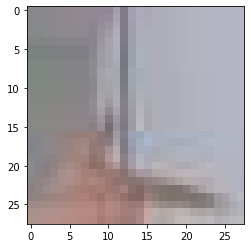

In [8]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [9]:
#화질 개선하기

def denoise_images(img_path):
    images = glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be denoised.")

    for img in images:
        old_img = cv2.imread(img)
        denoised_img = cv2.fastNlMeansDenoisingColored(old_img, None, 10, 10, 7, 21)
        cv2.imwrite(img, denoised_img)
        
    print(len(images), " images denoised.")

라벨:  0


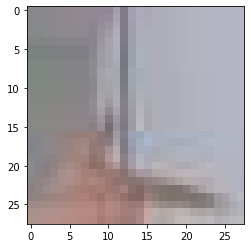

In [10]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 딥러닝 네트워크 학습시키기

In [11]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


model.fit(x_train, y_train, epochs=20)

Epoch 1/20
66/66 [==============================] - 3s 5ms/step - loss: 6.0850 - accuracy: 0.3452
Epoch 2/20
66/66 [==============================] - 0s 3ms/step - loss: 1.3112 - accuracy: 0.4976
Epoch 3/20
66/66 [==============================] - 0s 3ms/step - loss: 0.9127 - accuracy: 0.6467
Epoch 4/20
66/66 [==============================] - 0s 3ms/step - loss: 0.6979 - accuracy: 0.7190
Epoch 5/20
66/66 [==============================] - 0s 3ms/step - loss: 0.5403 - accuracy: 0.7800
Epoch 6/20
66/66 [==============================] - 0s 4ms/step - loss: 0.3438 - accuracy: 0.8629
Epoch 7/20
66/66 [==============================] - 0s 4ms/step - loss: 0.2383 - accuracy: 0.9114
Epoch 8/20
66/66 [==============================] - 0s 4ms/step - loss: 0.2013 - accuracy: 0.9410
Epoch 9/20
66/66 [==============================] - 0s 3ms/step - loss: 0.1748 - accuracy: 0.9500
Epoch 10/20
66/66 [==============================] - 0s 3ms/step - loss: 0.1371 - accuracy: 0.9700
Epoch 11/20
66/66 [

### 얼마나 잘 만들었는지 확인하기(테스트)

In [12]:
# 테스트 이미지 resize
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("테스트 이미지 resize 완료!")

500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.
500  images to be resized.
500  images resized.
테스트 이미지 resize 완료!


In [13]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path, 1500)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 1500 입니다.
x_test shape: (1500, 28, 28, 3)
y_test shape: (1500,)


라벨:  0


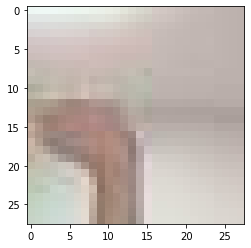

In [14]:
# 테스트 이미지 확인
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

In [15]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")


47/47 - 0s - loss: 1.0979 - accuracy: 0.3313
test_loss: 1.097931146621704
test_accuracy: 0.33133333921432495


## 회고

이번 프로젝트는 시간 투자를 제일 못한 프로젝트여서 임무를 완수하지 못했다.
이미지를 resize 하는 방법도 다양하고 이미지 품질을 향상시키고 싶었다. 향상하는 데는 이미지 대비를 조정하거나 노이즈 제거를 할 예정이다.
test 데이터나 train 데이터를 얼마나 어떻게 수집해서 향상시킬수 있을지 궁금하다.

그래도 처음에 과적합 된 부분은 보완해서 정상적인 test_accuracy 값을 구할 수 있었다. 비록, 33%밖에 안 되지만 꼭 돌아와서 60% 이상까지 구현해 볼 것이다.